In [1]:
import sys

In [2]:
sys.path.append('..')

In [87]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from helpers import CausalModel, lfilter
from copy import deepcopy
import seaborn as sns

In [4]:
%matplotlib Inline

In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

In [7]:
def create_standardizer_destandardizer(s: np.ndarray) -> np.ndarray:
    return lambda x: (x - s.mean()) / s.std(), lambda x: (x * s.std()) + s.mean()

## The Haunted DAG & The Causal Terror

### Code 6.1

Correlation on complete group 0.027
Correlation on selected group -0.626


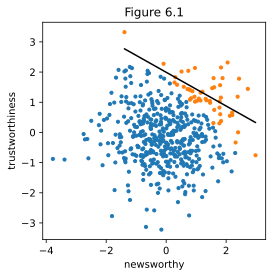

In [8]:
N = 500
p = .1

nw = np.random.normal(size=N)
tw = np.random.normal(size=N)

s = nw + tw

q = np.quantile(s, 1-p)
selected = s >= q

print(f'Correlation on complete group {np.corrcoef(tw, nw)[1, 0]:.3f}')
print(f'Correlation on selected group {np.corrcoef(tw[selected], nw[selected])[1, 0]:.3f}')

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(nw[~selected], tw[~selected], s=10)
ax.scatter(nw[selected], tw[selected], s=10)

beta, alpha = np.polyfit(nw[selected], tw[selected], 1)
ax.plot(nw[selected], alpha + beta*nw[selected], color='black')

ax.set_title('Figure 6.1')
ax.set_xlabel('newsworthy')
ax.set_ylabel('trustworthiness')
plt.show()

### Code 6.2

In [9]:
N = 100

height = np.random.normal(10, 2, size=N)
leg_prop = np.random.uniform(.4, .5, size=N)
leg_left = leg_prop*height + np.random.normal(0, .02, size=N)
leg_right = leg_prop*height + np.random.normal(0, .02, size=N)

d = pd.DataFrame({'height': height, 'leg_left': leg_left, 'leg_right': leg_right})

In [10]:
d.head()

,height,leg_left,leg_right
0,8.202,3.294,3.361
1,12.588,5.454,5.444
2,9.311,4.433,4.456
3,11.255,5.422,5.419
4,11.806,5.823,5.838


### Code 6.3

In [11]:
with pm.Model() as model_61:
    alpha = pm.Normal('alpha', 10, 100)
    beta_left = pm.Normal('beta_left', 2, 10)
    beta_right = pm.Normal('beta_right', 2, 10)
    sigma = pm.Exponential('sigma', 1)
    mu = alpha + beta_left*d['leg_left'] + beta_right*d['leg_right']
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace_61 = pm.sample()

/tmp/ipykernel_1056/3714563718.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_61 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_right, beta_left, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43418294194325835, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
az.summary(trace_61, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.262,0.270,0.797,1.693
beta_left,2.775,2.266,0.309,6.997
beta_right,-0.826,2.268,-4.949,1.744
sigma,0.621,0.052,0.557,0.698


In [13]:
with pm.Model() as model_61b:
    pm.glm.GLM.from_formula(
        formula='height ~ leg_left + leg_right', 
        data=d,
        priors={
            'Intercept': pm.Normal.dist(10, 100),
            'Regressor': pm.Normal.dist(2, 10),
            'sd': pm.Exponential.dist(1)
        }
    )
    trace_61b = pm.sample()

/tmp/ipykernel_1056/3594111202.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_61b = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, leg_right, leg_left, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8948020115529982, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [14]:
az.summary(trace_61b, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.259,0.304,0.802,1.777
leg_left,3.359,2.160,-0.452,6.392
leg_right,-1.409,2.163,-4.578,2.279
sd,0.641,0.045,0.561,0.702


### Code 6.4

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


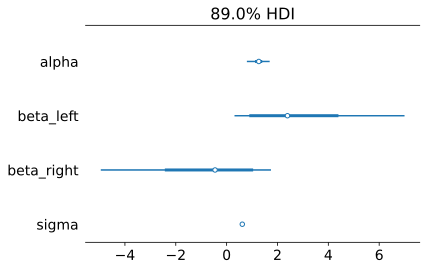

In [15]:
fig, ax = plt.subplots()
az.plot_forest(trace_61, hdi_prob=.89, combined=True, ax=ax)
plt.show()

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


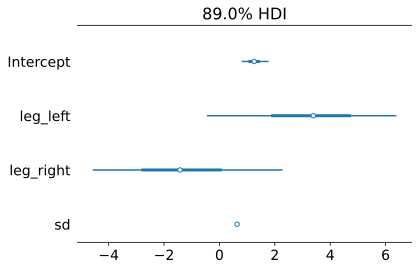

In [16]:
fig, ax = plt.subplots()
az.plot_forest(trace_61b, hdi_prob=.89, combined=True, ax=ax)
plt.show()

### Code 6.5-6.6

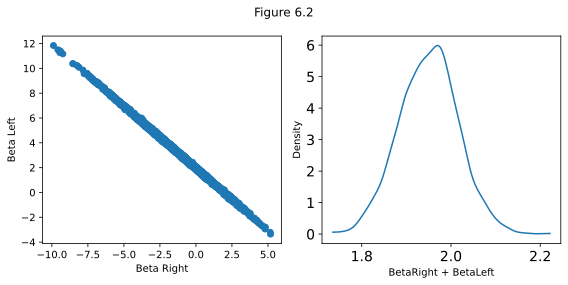

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(trace_61b['leg_right'], trace_61b['leg_left'])
ax1.set_xlabel('Beta Right')
ax1.set_ylabel('Beta Left')

az.plot_dist(trace_61b['leg_right'] + trace_61b['leg_left'], ax=ax2)
ax2.set_xlabel('BetaRight + BetaLeft')
ax2.set_ylabel('Density')

fig.suptitle('Figure 6.2')
fig.tight_layout()
plt.show()

### Code 6.7

In [18]:
with pm.Model() as model_62:
    pm.glm.GLM.from_formula(
        formula="height ~ leg_left",
        data=d,
        priors={
            "Intercept": pm.Normal.dist(10, 100),
            "Regressor": pm.Normal.dist(2, 10),
            "sd": pm.Exponential.dist(1)
        }
    )
    
    trace_62 = pm.sample()

/tmp/ipykernel_1056/446922992.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_62 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, leg_left, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [19]:
az.summary(trace_62, hdi_prob=.89, kind='stats')

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.247,0.307,0.789,1.751
leg_left,1.951,0.066,1.853,2.061
sd,0.640,0.048,0.560,0.711


### Code 6.8

In [20]:
d = pd.read_csv('../../data/milk.csv', sep=';')

std_K, dstd_K = create_standardizer_destandardizer(d['kcal.per.g'])
std_F, dstd_F = create_standardizer_destandardizer(d['perc.fat'])
std_L, dstd_L = create_standardizer_destandardizer(d['perc.lactose'])

d['K'] = std_K(d['kcal.per.g'])
d['F'] = std_F(d['perc.fat'])
d['L'] = std_L(d['perc.lactose'])

### Code 6.9

In [21]:
with pm.Model() as model_63:
    pm.glm.GLM.from_formula(
        formula='K ~ F',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_63 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/78259060.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_63 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, F, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.7029571538625417, but should be close to 0.8. Try to increase the number of tuning steps.


In [22]:
with pm.Model() as model_64:
    pm.glm.GLM.from_formula(
        formula='K ~ L',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_64 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/3276022010.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_64 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, L, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 26 seconds.


In [23]:
az.summary(trace_63, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.000,0.085,-0.133,0.134
F,0.857,0.094,0.711,1.008
sd,0.492,0.072,0.381,0.599


In [24]:
az.summary(trace_64, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.000,0.073,-0.115,0.115
L,-0.898,0.080,-1.023,-0.770
sd,0.415,0.061,0.319,0.505


### Code 6.10

In [25]:
with pm.Model() as model_65:
    pm.glm.GLM.from_formula(
        formula='K ~ L + F',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_65 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/1703585172.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_65 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, F, L, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 46 seconds.


In [26]:
az.summary(trace_65, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.000,0.072,-0.119,0.111
L,-0.664,0.200,-0.986,-0.352
F,0.255,0.199,-0.055,0.578
sd,0.419,0.061,0.322,0.508


### Code 6.11

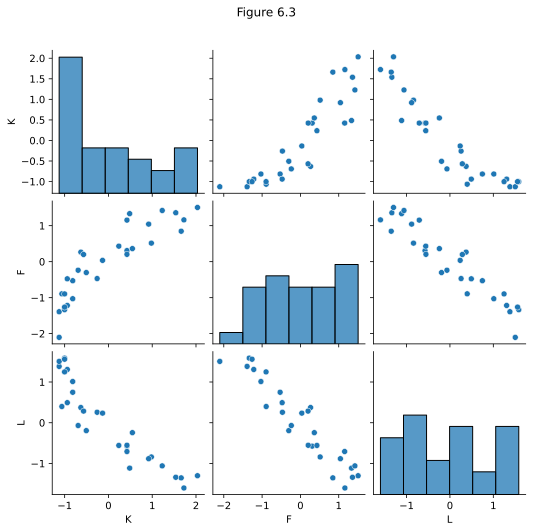

In [27]:
pp = sns.pairplot(d[['K', 'F', 'L']])
pp.fig.subplots_adjust(top=0.9)
pp.fig.suptitle('Figure 6.3')
plt.show()

### Code 6.12

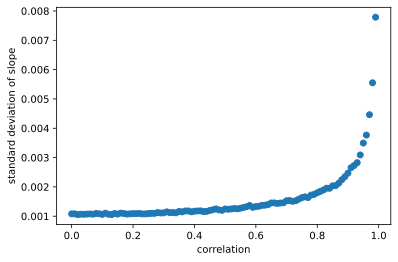

In [28]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(d, r=.9):
    d = d.copy()
    d['x'] = np.random.normal(
        r*d['perc.fat'],
        np.sqrt((1-r**2) * np.var(d['perc.fat']))
    )
    _, cov = curve_fit(mv, (d["perc.fat"], d['x']), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(d, r=0.9, n=100):
    return np.mean([sim_coll(d, r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(lambda x: rep_sim_coll(d, x), r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

### Code 6.13

In [29]:
N = 100

h0 = np.random.normal(10, 2, N)

treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
p = h1/h0

d = pd.DataFrame({
    "h0": h0,
    "h1": h1,
    "treatment": treatment,
    "fungus": fungus,
    "p": p,
})

d.describe()

,h0,h1,treatment,fungus,p
count,100.000,100.000,100.000,100.000,100.000
mean,9.859,13.812,0.500,0.310,1.413
std,1.896,2.702,0.503,0.465,0.204
min,5.357,7.316,0.000,0.000,0.928
25%,8.470,11.823,0.000,0.000,1.252
50%,9.740,14.203,0.500,0.000,1.456
75%,10.982,15.557,1.000,1.000,1.556
max,14.650,19.844,1.000,1.000,1.816


### Code 6.14

In [30]:
sim_p = pd.Series(np.random.lognormal(0, .25, size=1000))


In [31]:
sim_p.describe()

count   1,000.000
mean        1.022
std         0.253
min         0.469
25%         0.850
50%         0.995
75%         1.159
max         2.592
dtype: float64

<AxesSubplot:>

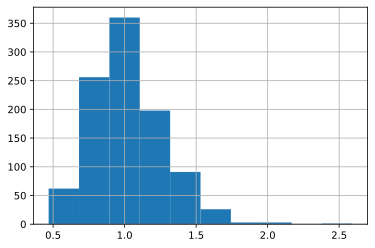

In [32]:
sim_p.hist()

### Code 6.15

In [33]:
with pm.Model() as model_66:
    p = pm.Lognormal('p', 0, .25)
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', p * d['h0'], sigma, observed=d['h1'])
    
    trace_66 = pm.sample(10_000, tune=10_000)

/tmp/ipykernel_1056/1132193321.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_66 = pm.sample(10_000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 15 seconds.


In [34]:
az.summary(trace_66, hdi_prob=.89, kind='stats', round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
p,1.390,0.020,1.350,1.420
sigma,1.960,0.140,1.740,2.180


### Code 6.16

In [35]:
with pm.Model() as model_67:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment + fungus',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_67 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/2137954593.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_67 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, fungus, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.7148918013467219, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6696033268686795, but should be close to 0.8. Try to increase the number of tuning steps.


In [36]:
az.summary(trace_67, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.450,0.030,1.410,1.500
treatment,0.090,0.030,0.040,0.130
fungus,-0.290,0.030,-0.340,-0.240
sd,0.120,0.010,0.110,0.140


### Code 6.17

In [37]:
d['p'] = d['h1'] / d['h0']

with pm.Model() as model_68:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_68 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/1243007833.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_68 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.6894970627888699, but should be close to 0.8. Try to increase the number of tuning steps.


In [38]:
az.summary(trace_68, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.280,0.020,1.240,1.320
treatment,0.240,0.040,0.180,0.300
sd,0.170,0.010,0.150,0.190


### Code 6.18

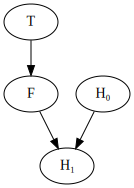

In [39]:
plant_dag = CausalModel(
    nodes=['H\N{SUBSCRIPT ZERO}', 'H\N{SUBSCRIPT ONE}', 'F', 'T'],
    edges=[
        ('H\N{SUBSCRIPT ZERO}', 'H\N{SUBSCRIPT ONE}'),
        ('F', 'H\N{SUBSCRIPT ONE}'),
        ('T', 'F'),
    ]
)

plant_dag.draw()

### Code 6.19

In [40]:
plant_dag.get_all_independence_relationships()

[('T', 'H₁', {'F'}),
 ('T', 'H₁', {'F', 'H₀'}),
 ('T', 'H₀', set()),
 ('T', 'H₀', {'F'}),
 ('T', 'H₀', {'F', 'H₁'}),
 ('F', 'H₀', set()),
 ('F', 'H₀', {'T'})]

In [41]:
plant_dag.get_implied_conditional_independencies()

[('T', 'H₁', {'F'}), ('T', 'H₀', set()), ('F', 'H₀', set())]

### Code 6.20

In [42]:
N = 1000

h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(n=1, p=0.5, size=N)
fungus = np.random.binomial(n=1, p=0.5 - .4*treatment + .4*M, size=N)
h1 = h0 + np.random.normal(5 + 3*M, size=N)
p = h1/h0

d2 = pd.DataFrame({
    "h0": h0,
    "h1": h1,
    "treatment": treatment,
    "fungus": fungus,
    "p": p,
})

d2.describe()

,h0,h1,treatment,fungus,p
count,"1,000.000","1,000.000","1,000.000","1,000.000","1,000.000"
mean,10.040,16.533,0.500,0.490,1.678
std,2.025,2.713,0.500,0.500,0.252
min,2.797,7.406,0.000,0.000,1.177
25%,8.755,14.696,0.000,0.000,1.489
50%,10.021,16.478,0.500,0.000,1.639
75%,11.400,18.389,1.000,1.000,1.830
max,16.135,24.947,1.000,1.000,3.327


In [43]:
d2['p'] = d2['h1'] / d2['h0']

with pm.Model() as model_672:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment + fungus',
        data=d2,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_672 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/2727862862.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_672 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, fungus, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 188 seconds.
The acceptance probability does not match the target. It is 0.8848439853629237, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.696950914772786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900973534832805, but should be close to 0.8. Try to increase the number of tuning steps.


In [44]:
az.summary(trace_672, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.560,0.020,1.540,1.590
treatment,0.080,0.020,0.050,0.110
fungus,0.150,0.020,0.120,0.180
sd,0.240,0.010,0.240,0.250


In [45]:
d['p'] = d['h1'] / d['h0']

with pm.Model() as model_682:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment',
        data=d2,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_682 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_1056/335932195.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_682 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 146 seconds.


In [46]:
az.summary(trace_682, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.670,0.010,1.650,1.680
treatment,0.020,0.020,-0.010,0.040
sd,0.250,0.010,0.240,0.260


/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


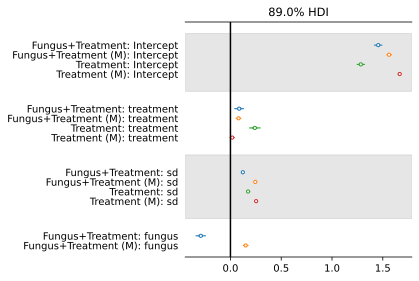

In [47]:
fig, ax = plt.subplots()

az.plot_forest(
    data=[trace_67, trace_672, trace_68, trace_682],
    model_names=['Fungus+Treatment', 'Fungus+Treatment (M)', 'Treatment', 'Treatment (M)'],
    combined=True,
    hdi_prob=.89,
    ax=ax,
    textsize=10,
)
ax.axvline(0, color='black')
fig.tight_layout()
plt.show()

### Code 6.21

In [48]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def create_pop(n):
    population = pd.DataFrame({
        'age': np.zeros(shape=n),
        'happiness': np.linspace(start=-2, stop=2, num=n),
        'married': np.zeros(shape=n, dtype='bool')
    })
    
    return population

def sim_happiness(born_on_year: int = 20, 
                  max_age: int = 65, 
                  n_years: int = 100) -> pd.DataFrame:
    
    population = create_pop(born_on_year)
    
    for _ in range(n_years):
        population['age'] += 1
        
        # Create and remove pop
        population = population[population['age'] < 65]
        population = pd.concat([population, create_pop(born_on_year)], ignore_index=True)
        
        # Marry pop
        marriable = (population['age'] > 18) & (population['married'] == False)
        marrying = np.random.binomial(n=1, p=inv_logit(population.loc[marriable, "happiness"] - 4)).astype('bool')
        population.loc[marriable, 'married'] = marrying
        
    return population

d = sim_happiness(n_years=1000)

d.describe().T

,count,mean,std,min,25%,50%,75%,max
age,"1,300.000",32.000,18.769,0.000,16.000,32.000,48.000,64.000
happiness,"1,300.000",-0.000,1.214,-2.000,-1.000,-0.000,1.000,2.000


### Code 6.22

In [49]:
d2 = d[d['age'] >= 18].reset_index(drop=True)
d2['age_norm'] = (d2['age'] - d2['age'].min()) / (d2['age'].max() - d2['age'].min())

### Code 6.23

In [50]:
with pm.Model() as model_69:
    pm.glm.GLM.from_formula(
        formula='happiness ~ -1 + age_norm + C(married)',
        data=d2,
        priors={
            'C(married)[True]': pm.Normal.dist(0, 1),
            'C(married)[False]': pm.Normal.dist(0, 1),
            'age_norm': pm.Normal.dist(0, 2),
        }
    )
    
    trace_69 = pm.sample(10_000, tune=20_000)

az.summary(trace_69, kind='stats', hdi_prob=.89, round_to=2)

/tmp/ipykernel_1056/4268959170.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_69 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, age_norm, C(married)[True], C(married)[False]]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 185 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
C(married)[False],-0.190,0.070,-0.300,-0.080
C(married)[True],1.270,0.090,1.130,1.420
age_norm,-0.710,0.120,-0.910,-0.530
sd,1.010,0.020,0.970,1.050


### Code 6.24

In [51]:
with pm.Model() as model_610:
    pm.glm.GLM.from_formula(
        formula='happiness ~ -1 + age_norm',
        data=d2,
        priors={
            'age_norm': pm.Normal.dist(0, 2),
        }
    )
    
    trace_610 = pm.sample(10_000, tune=20_000)

az.summary(trace_610, kind='stats', hdi_prob=.89, round_to=2)

/tmp/ipykernel_1056/2836782778.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_610 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, age_norm]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 25 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
age_norm,-0.000,0.070,-0.110,0.110
sd,1.220,0.030,1.170,1.260


### Code 6.25

In [52]:
N = 200 # Number of samples
b_GP = 1 # direct effect of Grandparents on Parents
b_GC = 0 # direct effect of Grandparents on Children
b_PC = 1 # direct effect of Parents on Children
b_U = 2 # direct effect of Unknown on Parents and Children

### Code 6.26

In [53]:
U = 2 * stats.bernoulli(p=.5).rvs(N) - 1
G = stats.norm().rvs(N)
P = stats.norm(b_GP*G + b_U*U).rvs(N)
C = stats.norm(b_GC*G + b_U*U + b_PC*P).rvs(N)

d = pd.DataFrame({
    'U': U,
    'G': G,
    'P': P,
    'C': C,
})

d.head()

,U,G,P,C
0,1,-1.036,1.435,4.170
1,1,-0.623,0.941,2.040
2,-1,0.460,-0.804,-3.520
3,-1,1.106,-0.048,-2.117
4,1,-0.623,1.858,3.095


### Code 6.27

In [54]:
with pm.Model() as model_611:
    pm.glm.GLM.from_formula(
        formula="C ~ P + G",
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, 1),
            'Regressor': pm.Normal.dist(0, 1),
        }
    )
    
    trace_611 = pm.sample(10_000, tune=20_000)
    
az.summary(trace_611, kind='stats', hdi_prob=.89)

/tmp/ipykernel_1056/4101515830.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_611 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, G, P, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.7036358434532324, but should be close to 0.8. Try to increase the number of tuning steps.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.102,0.092,-0.249,0.046
P,1.857,0.044,1.787,1.926
G,-0.779,0.102,-0.936,-0.610
sd,1.307,0.067,1.200,1.413


### Code 6.28

In [55]:
with pm.Model() as model_612:
    pm.glm.GLM.from_formula(
        formula="C ~ P + G + U",
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, 1),
            'Regressor': pm.Normal.dist(0, 1),
        }
    )
    
    trace_612 = pm.sample(10_000, tune=20_000)
    
az.summary(trace_612, kind='stats', hdi_prob=.89)

/tmp/ipykernel_1056/2740015589.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_612 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, U, G, P, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 48 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,-0.075,0.072,-0.188,0.040
P,1.041,0.078,0.914,1.163
G,0.069,0.107,-0.099,0.243
U,1.945,0.168,1.680,2.220
sd,1.004,0.052,0.924,1.087


### Code 6.29

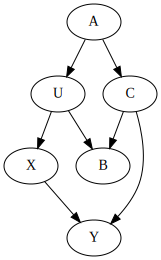

In [95]:
dag_61 = CausalModel(
    nodes=['A', 'B', "C", "X", "Y", "U"],
    edges=[
        ('A', 'C'),
        ('A', 'U'),
        ('C', 'B'),
        ('C', 'Y'),
        ('X', 'Y'),
        ('U', 'X'),
        ('U', 'B'),
    ]
)

dag_61.draw()

In [96]:
lfilter(lambda x: x != {"U"}, dag_61.get_adjustment_sets('X', 'Y'))

[frozenset({'C'}), frozenset({'A'})]

### Code 6.30

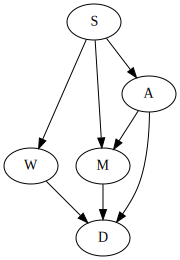

In [97]:
dag_62 = CausalModel(
    nodes=['S', 'W', "M", "A", "D"],
    edges=[
        ('S', 'W'),
        ('S', 'A'),
        ('S', 'M'),
        ('W', 'D'),
        ('M', 'D'),
        ('A', 'D'),
        ('A', 'M'),
    ]
)

dag_62.draw()

In [98]:
dag_62.get_adjustment_sets('W', 'D')

[frozenset({'S'}), frozenset({'A', 'M'})]